# Task 1: Warming Stripes

## Subtask 1.1
Select the stations which are (1) in Bayern, (2) still active and (3) started before 1950. It should be # stations.

In [68]:
import pandas as pd
import geopandas as gpd

In [69]:
data_in_dir = r"./data/original/"
stations_fname = r"KL_Jahreswerte_Beschreibung_Stationen.txt"

stations_pfname = data_in_dir + stations_fname

print(f"Stationsdaten:  {stations_pfname:s}")

Stationsdaten:  ./data/original/KL_Jahreswerte_Beschreibung_Stationen.txt


In [70]:
# reading the textfile using a pandas dataframe

cnames = ["stations_id", "von_datum", "bis_datum", "Stationshoehe", "geoBreite", "geoLaenge", "Stationsname", "Bundesland", "Abgabe"]


df = pd.read_fwf(stations_pfname, skiprows=[0, 1],  encoding = "latin", names = cnames, index_col = "stations_id", parse_dates=["von_datum", "bis_datum"] )
df.head()

,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,Abgabe
stations_id,,,,,,,,
1,1931-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg,Frei
3,1851-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen,Frei
44,1971-03-01,2024-12-31,44,52.9336,8.2370,Großenkneten,Niedersachsen,Frei
52,1973-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein,Frei
61,1975-07-01,1978-08-31,339,48.8443,12.6171,Aiterhofen,Bayern,Frei


In [72]:
#creating a new data frame containing only the stations that fulfill the conditions

place = "Bayern"
start_date = "1950-01-01"
n_df = df[(df["Bundesland"]== place) & (df["von_datum"] < start_date) & (df["bis_datum"] >= "2024-12-31")]
n_df.head()


,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,Abgabe
stations_id,,,,,,,,
151,1947-01-01,2024-12-31,382,49.4691,11.8546,Amberg-Unterammersricht,Bayern,Frei
191,1884-01-01,2024-12-31,217,49.9694,9.9114,Arnstein-Müdesheim,Bayern,Frei
217,1938-01-01,2024-12-31,670,47.8774,11.3643,Attenkam,Bayern,Frei
232,1947-01-01,2024-12-31,462,48.4253,10.9417,Augsburg,Bayern,Frei
282,1881-01-01,2024-12-31,240,49.8743,10.9206,Bamberg,Bayern,Frei


In [34]:
# saving the newer dataframe as a csv file

data_out_pfname = r"./data/original/yearly_average_temp_Bayern.csv"
n_df.to_csv(data_out_pfname)


## Subtask 1.2
Use geopandas in your Jupyter notebook to create a geopackage layer with exactly the stations matching the above criteria. Load this into QGIS and use the Bayern WMS service with the topographic map collection as a background map DTK500. Create a nicely designed and completely annotated map using EPSG:25832. Use the station IDs together with the station names as labels.

In [35]:
import geopandas as gpd

data_out_geopackage = r"./data/derived/weather_stations_bayern.gpkg"


# convering the dataframe into a GeoDataFrame 
gdf = gpd.GeoDataFrame(n_df, geometry=gpd.points_from_xy(n_df["geoLaenge"], n_df["geoBreite"]), crs="EPSG:25832")

# saving it to a geopackage file
gdf.to_file(data_out_geopackage, layer="stations", driver="GPKG")

print("GeoPackage saved successfully!")


GeoPackage saved successfully!


#### Below the map created with QGIS can be observed. Labels, a legend, scale and a north arrow were added, also the symbology was changed.

![Map produced](data/derived/map_stations_bayern_2.png)


## Subtask 1.3
Extend your Jupyter notebook to automatically download (using ftplib, wget, or similar) the annual temperature data from the KL data collection, i.e. which automatically downloads the data according to the selected station IDs in the station info dataframe from here: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/annual/kl/historical/

In [11]:
# looping through the stations id column to only download the selected ones.

import os

# url of website
base_url = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/annual/kl/historical/"


for station_id in n_df.index:

    file_name = f"jahreswerte_KL_{station_id}.zip"
    url = base_url + file_name

    # download files using wget
    os.system(f"wget -c {url}")  # -c ensures it continues downloading if interrupted

print("Download completed!")


Download completed!


In [12]:
from ftplib import FTP
import os

# FTP server details
ftp_host = "opendata.dwd.de"
ftp_dir = "/climate_environment/CDC/observations_germany/climate/annual/kl/historical/"


In [13]:
# createating a folder for downloads
download_folder = "data/original/dwd_data_zipped"
os.makedirs(download_folder, exist_ok=True)

# connecting to FTP
ftp = FTP(ftp_host)
ftp.login()  # anonymous login
ftp.cwd(ftp_dir)

'250 Directory successfully changed.'

In [14]:
# list all files in the directory
files = ftp.nlst()

# loop through station IDs (using index)
for station_id in n_df.index:
    file_pattern = f"jahreswerte_KL_{str(station_id).zfill(5)}_"

    # find matching files
    matching_files = [file for file in files if file_pattern in file]

    if matching_files:
        filename = matching_files[0]  # Take the first match
        local_path = os.path.join(download_folder, filename)

        # downloading the file
        with open(local_path, "wb") as f:
            ftp.retrbinary(f"RETR {filename}", f.write)
        print(f"Downloaded: {filename}")
    else:
        print(f"No file found for station {station_id}")

# close the FTP connection
ftp.quit()

print("Download process completed!")

Downloaded: jahreswerte_KL_00151_19470101_20231231_hist.zip
Downloaded: jahreswerte_KL_00191_18840101_20231231_hist.zip
Downloaded: jahreswerte_KL_00217_19380101_20231231_hist.zip
Downloaded: jahreswerte_KL_00232_19470101_20231231_hist.zip
Downloaded: jahreswerte_KL_00282_19490101_20231231_hist.zip
Downloaded: jahreswerte_KL_00320_18510101_20231231_hist.zip
Downloaded: jahreswerte_KL_00867_18830101_20231231_hist.zip
Downloaded: jahreswerte_KL_01103_19380101_20231231_hist.zip
Downloaded: jahreswerte_KL_01107_19480101_20231231_hist.zip
Downloaded: jahreswerte_KL_01279_18810101_20231231_hist.zip
Downloaded: jahreswerte_KL_01332_19370101_20231231_hist.zip
Downloaded: jahreswerte_KL_01357_19470101_20231231_hist.zip
Downloaded: jahreswerte_KL_01550_18890101_20231231_hist.zip
Downloaded: jahreswerte_KL_02261_19470101_20231231_hist.zip
Downloaded: jahreswerte_KL_02290_17810101_20231231_hist.zip
Downloaded: jahreswerte_KL_02480_18960101_20231231_hist.zip
Downloaded: jahreswerte_KL_02559_1881010

## Sub-Task 1.4:
Use the dataframe with the temperature time series merged columnwise together with seaborn to plot the warming stripes. The diagram with five stations and not including recent data (2023 missing) looks like:

Warming Stripes NRW
![Map produced](data/original/NRW_Annual_Temp_github.png)


Create a similar plot but for the selected stations including the annual temperature data of 2022. Let the time series run from 1950 to 2022.

Note that for a station with ID sno, the temperature ΔTsno(k) shown in year k is the negative (blue) or positive (red) deviation from the reference temperature T¯sno, which is the mean annual temperature of the station between 1971 and 2000.

ΔTsno(k)=Tsno(k)−T¯sno

### STEPS
* Read & parse the annual data for each station from the downloaded .zip files.
* Filter to the range 1950–2022.
* Calculate the reference mean (1971–2000) for each station.
* Compute anomalies (yearly temperature – reference mean).
* Combine all station anomalies into a single DataFrame.
* Use seaborn to plot a heatmap of these anomalies for a warming stripes visualization.

In [23]:
import zipfile

# Folder with the .zip files
zip_folder = "./data/original/dwd_data_ziped"

# Folder where you want to extract everything
unzipped_folder = "./data/derived/dwd_data_extracted"
os.makedirs(unzipped_folder, exist_ok=True)


for file_name in os.listdir(zip_folder):
    if file_name.endswith(".zip"):
        zip_path = os.path.join(zip_folder, file_name)
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(unzipped_folder)

In [38]:
dfs = [] # creating a list so it can contain the created data frames

for extracted_file in os.listdir(unzipped_folder):
    # Only processing files that start with "produkt_klima_jahr_"
    if extracted_file.startswith("produkt_klima_jahr_"):
        file_path = os.path.join(unzipped_folder, extracted_file)
        df = pd.read_csv(file_path, sep=';', header=0) 
        dfs.append(df)

print(f"Loaded {len(dfs)} DataFrames.")
dfs[1]

Loaded 45 DataFrames.


,STATIONS_ID,MESS_DATUM_BEGINN,MESS_DATUM_ENDE,QN_4,JA_N,JA_TT,JA_TX,JA_TN,JA_FK,JA_SD_S,JA_MX_FX,JA_MX_TX,JA_MX_TN,QN_6,JA_RR,JA_MX_RS,eor
0,320,18510101,18511231,5,-999.0,6.92,-999.00,-999.00,-999.0,-999.00,-999.0,-999.0,-999.0,5,795.0,-999.0,eor
1,320,18520101,18521231,5,-999.0,8.60,-999.00,-999.00,-999.0,-999.00,-999.0,-999.0,-999.0,5,651.0,-999.0,eor
2,320,18530101,18531231,5,-999.0,6.42,-999.00,-999.00,-999.0,-999.00,-999.0,-999.0,-999.0,5,684.0,-999.0,eor
3,320,18540101,18541231,5,-999.0,7.06,-999.00,-999.00,-999.0,-999.00,-999.0,-999.0,-999.0,5,825.0,-999.0,eor
4,320,18550101,18551231,5,-999.0,6.15,-999.00,-999.00,-999.0,-999.00,-999.0,-999.0,-999.0,5,638.0,-999.0,eor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,320,20190101,20191231,10,-999.0,9.68,15.34,3.84,-999.0,1885.30,-999.0,37.4,-12.0,9,599.0,35.3,eor
169,320,20200101,20201231,10,-999.0,9.54,14.99,3.85,-999.0,1860.80,-999.0,35.1,-8.4,9,652.6,44.0,eor
170,320,20210101,20211231,10,-999.0,8.36,13.55,3.36,-999.0,1697.60,-999.0,33.3,-20.3,9,722.0,40.0,eor
171,320,20220101,20221231,10,-999.0,9.90,15.58,3.95,-999.0,1972.00,-999.0,37.4,-19.3,3,622.6,27.5,eor


In [56]:
import numpy as np

for df_station in dfs:
    # Calculating reference temperature (1971–2000)
    ref_period = df_station[(df_station["MESS_DATUM_BEGINN"] >= 19710101) & (df_station["MESS_DATUM_ENDE"] <= 20000101)]
    if ref_period.empty:
        continue  # Skip if reference period data is missing
    df_station["JA_TT"] = df_station["JA_TT"].replace(-999, np.nan)
    T_bar_sno = ref_period["JA_TT"].mean()
    
    # Computing the anomalies for the different years: ΔT = TMK - T_bar_sno
    if ref_period.empty:
        continue  # Skip if reference period data is missing
    
    df_station["anomaly"] = df_station["JA_TT"] - T_bar_sno


In [57]:
dfs[44]

,STATIONS_ID,MESS_DATUM_BEGINN,MESS_DATUM_ENDE,QN_4,JA_N,JA_TT,JA_TX,JA_TN,JA_FK,JA_SD_S,JA_MX_FX,JA_MX_TX,JA_MX_TN,QN_6,JA_RR,JA_MX_RS,eor,anomaly
0,4592,19490101,19491231,5,-999.0,8.72,-999.00,-999.00,-999.0,-999.0,-999,-999.0,-999.0,5,509.8,27.6,eor,0.808966
1,4592,19500101,19501231,-999,-999.0,NaN,-999.00,-999.00,-999.0,-999.0,-999,-999.0,-999.0,5,661.7,20.6,eor,NaN
2,4592,19510101,19511231,-999,-999.0,NaN,-999.00,-999.00,-999.0,-999.0,-999,-999.0,-999.0,5,545.6,27.6,eor,NaN
3,4592,19520101,19521231,-999,-999.0,NaN,-999.00,-999.00,-999.0,-999.0,-999,-999.0,-999.0,5,817.1,28.0,eor,NaN
4,4592,19530101,19531231,-999,-999.0,NaN,-999.00,-999.00,-999.0,-999.0,-999,-999.0,-999.0,5,397.9,20.0,eor,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,4592,20190101,20191231,10,-999.0,10.22,15.89,5.03,-999.0,1953.1,-999,37.4,-9.9,9,553.0,29.3,eor,2.308966
69,4592,20200101,20201231,10,-999.0,9.99,15.40,4.95,-999.0,1863.9,-999,35.4,-9.0,9,603.6,47.3,eor,2.078966
70,4592,20210101,20211231,10,-999.0,8.98,14.28,4.23,-999.0,1704.6,-999,34.0,-15.8,9,659.6,33.5,eor,1.068966
71,4592,20220101,20221231,10,-999.0,10.53,16.18,5.20,-999.0,1989.1,-999,38.3,-12.0,3,608.4,25.7,eor,2.618966


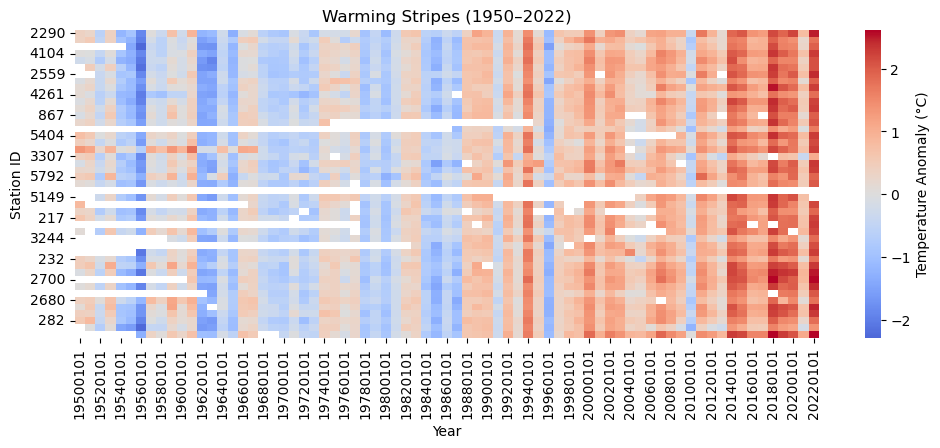

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt



# Combining all anomalies into one DataFrame
combined_df = pd.concat(
    {df['STATIONS_ID'].iloc[0]: df.set_index('MESS_DATUM_BEGINN')['anomaly'] for df in dfs},
    axis=1
)

combined_df = combined_df.loc[19500101:20220101]

# Checking the head of the combined DataFrame
# print(combined_df.head())

# ploting the warming stripes using seaborn's heatmap (below)
plt.figure(figsize=(12, 4))
sns.heatmap(
    combined_df.T,          # Transposing so that each station (row) shows a stripe along years (columns)
    cmap="coolwarm",        # Using a diverging colormap centered on 0
    center=0,
    cbar_kws={'label': 'Temperature Anomaly (°C)'}
)
plt.xlabel("Year")
plt.ylabel("Station ID")
plt.title("Warming Stripes (1950–2022)")

plt.savefig("./data/derived/warming_stripes_bavaria.png", dpi=300, bbox_inches="tight")

plt.show()


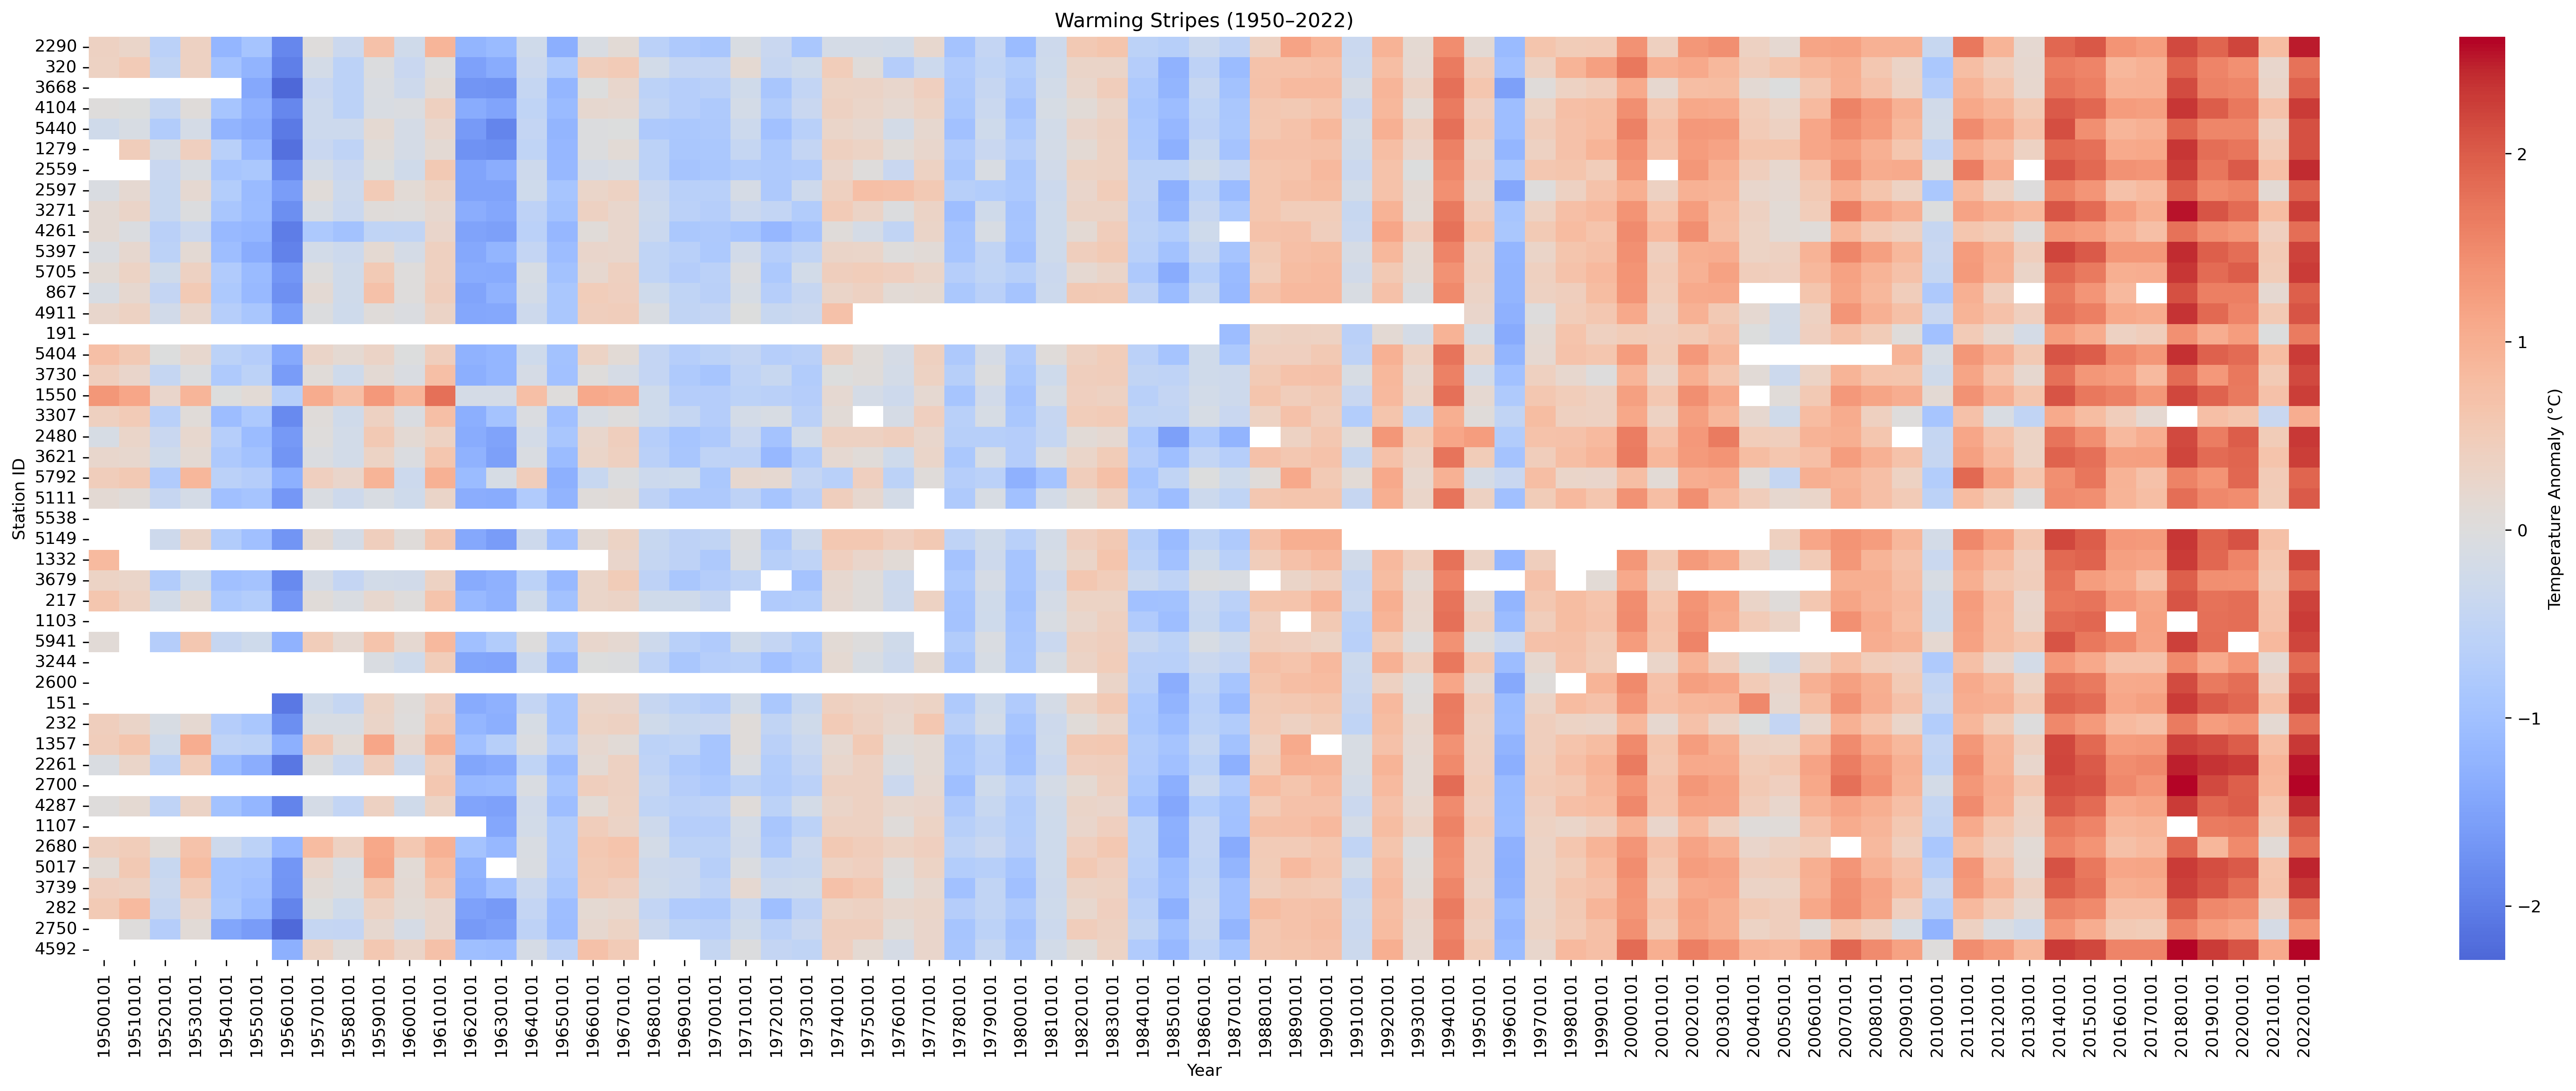

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt



# Combining all anomalies into one DataFrame
combined_df = pd.concat(
    {df['STATIONS_ID'].iloc[0]: df.set_index('MESS_DATUM_BEGINN')['anomaly'] for df in dfs},
    axis=1
)

combined_df = combined_df.loc[19500101:20220101]

# Checking the head of the combined DataFrame
# print(combined_df.head())

# ploting the warming stripes using seaborn's heatmap (below)
plt.figure(figsize=(30,10), dpi=300)
sns.heatmap(
    combined_df.T,          # Transposing so that each station (row) shows a stripe along years (columns)
    cmap="coolwarm",        # Using a diverging colormap centered on 0
    center=0,
    cbar_kws={'label': 'Temperature Anomaly (°C)'}
)
plt.xlabel("Year")
plt.ylabel("Station ID")
plt.title("Warming Stripes (1950–2022)")

plt.savefig("./data/derived/warming_stripes_bavaria2.png", dpi=300, bbox_inches="tight")

plt.show()

## PLOT RESULT

The following plot was obtained after following all the steps in the instructions. However it was not clarified how many stations had to be included in the plot, and in total there are 45 stations that meet the requirements, but i was only able to plot 15 of them, I hope that is enough. One solution I found is just creating 3 plots to include the 45 stations, but since it is very repetitive I hope that is not neccesary. 

![Map produced](data/derived/warming_stripes_bavaria1.png)



.